In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import schedule
import time
import os
import re
import subprocess
import pandas as pd
from pathlib import Path
import time
import threading


In [10]:
def get_all_thermal_zones():
    thermal_zones = []
    for folder in os.listdir('/sys/class/thermal/'):
        if folder.startswith('thermal_zone'):
            thermal_zones.append(os.path.join('/sys/class/thermal/', folder))
    return thermal_zones

def get_all_temperatures(thermal_zones):
    temperatures = []
    for zone_path in thermal_zones:
        temperature = get_temperature(zone_path)
        temperatures.append(temperature)
    return temperatures

def get_temperature(zone_path):
    with open(os.path.join(zone_path, 'temp'), 'r') as file:
        temperature = file.read().strip()
    return int(temperature) / 1000

def save_thermal_temperature(temporary_file, permanent_file, intervalo, duracao):
    thermal_zones = get_all_thermal_zones()
    tempo_total_execucao = duracao * 60  # Convertendo minutos para segundos
    inicio_execucao = time.time()

    # Verifica se o arquivo permanente já existe
    existe_arquivo_permanente = os.path.exists(permanent_file)

    with open(temporary_file, 'a') as q_temp:
        if not existe_arquivo_permanente:  # Se o arquivo permanente não existir
            label = "day;time;" + ";".join(zone.split('/')[-1] for zone in thermal_zones)
            q_temp.write(label + '\n')

        while time.time() - inicio_execucao < tempo_total_execucao:
            now = datetime.now().strftime("%Y-%m-%d;%H:%M:%S")  # Modificado para separar a data e a hora
            record = now.split(';')[0]  # Pegando apenas a data
            record += ';' + now.split(';')[1]  # Pegando apenas a hora

            temperatures = get_all_temperatures(thermal_zones)
            for temperature in temperatures:
                record += ';' + str(temperature)

            record += '\n'
            q_temp.write(record)
            time.sleep(intervalo * 60)

    # Copia o conteúdo do arquivo temporário para o arquivo permanente
    with open(temporary_file, 'r') as temp_file, open(permanent_file, 'a+') as perm_file:
        perm_file.write(temp_file.read())

    # Apaga os dados do arquivo temporário
    with open(temporary_file, 'w'):
        pass

    print("Coleta de temperaturas finalizadas.")

# Exemplo de uso
temporary_file = 'temperaturas_temporarias.csv'
permanent_file = 'historico_permanente_coletas_temperaturas.csv'
save_thermal_temperature(temporary_file, permanent_file, 1, 2)  # Coleta temperatura de todas as zonas térmicas a cada 1 minuto por 5 minutos




Coleta de temperaturas finalizadas.


In [28]:
def load_temperature_data():
    file_path = "historico_permanente_coletas_temperaturas.csv"
    return pd.read_csv(file_path, delimiter=';')

def plot_temperature_graph(dataframe, day):
    df_day = dataframe[dataframe['day'] == day]

    plt.figure(figsize=(10, 6))

    for column in df_day.columns[2:]:
        plt.plot(df_day['time'], df_day[column], label=column)

    plt.title(f"Temperatures for {day}")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()



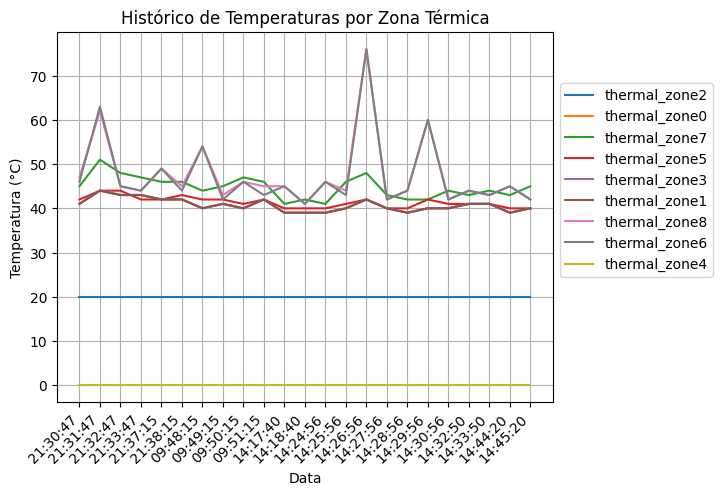

<Figure size 1000x600 with 0 Axes>

In [26]:
#gráfico histórico geral de temperaturas
# Carregar os dados do arquivo CSV
df = pd.read_csv('historico_permanente_coletas_temperaturas.csv', sep=';')

# Converter a coluna 'day' para o tipo datetime
df['day'] = pd.to_datetime(df['day'])


# Plotar um gráfico de linhas para cada zona térmica
for coluna in df.columns[2:]:  # Ignora as duas primeiras colunas (day e time)
    plt.plot(df['time'], df[coluna], label=coluna)

# Configurações adicionais do gráfico
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title('Histórico de Temperaturas por Zona Térmica')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.6))
plt.xticks(rotation=45, ha='right') 
plt.grid(True)
plt.figure(figsize=(10, 6))


# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [3]:
def save_info_proc_file(name_file ='info_proc.txt'):
    informacoes = {}
    
    with open('/proc/cpuinfo', 'r') as file:
        linhas = file.readlines()

    for linha in linhas:
        # Separa a linha em chave e valor
        partes = linha.strip().split(':')
        if len(partes) == 2:
            chave = partes[0].strip()
            valor = partes[1].strip()
            informacoes[chave] = valor

    with open(name_file, 'w') as file:
        for chave, valor in informacoes.items():
            file.write(f'{chave}: {valor}\n')

    print(f'Informações do processador salvas em {name_file}')


def print_several_temps_all_zones(file):
    df = pd.read_csv(file, sep=";", header=None)
    
    time_list = df[df.columns[1]].values.tolist()[1:]
    zones_dict = {}    
    all_zones_in_a_dictionary(zones_dict, df)
    print(zones_dict)
    zonesdict = zones_dict
    
    df = pd.DataFrame(data=zonesdict)
    df.index = time_list
    lines = df.plot.line(figsize=(10, 4))
    
#funcao nova
def all_zones_in_a_dictionary(zones_dict, df):

    for i in range(2, df.shape[1]):
        print("accessing position:", i)
        zone_name = df[df.columns[i]].values.tolist()[0]
        temp_list = df[df.columns[i]].values.tolist()[1:]
        temp_list_2 = [float(element) for element in temp_list]

        zones_dict[str(zone_name)] = temp_list_2
    return zones_dict

Digite o dia que deseja plotar (YYYY-MM-DD): 2024-03-19


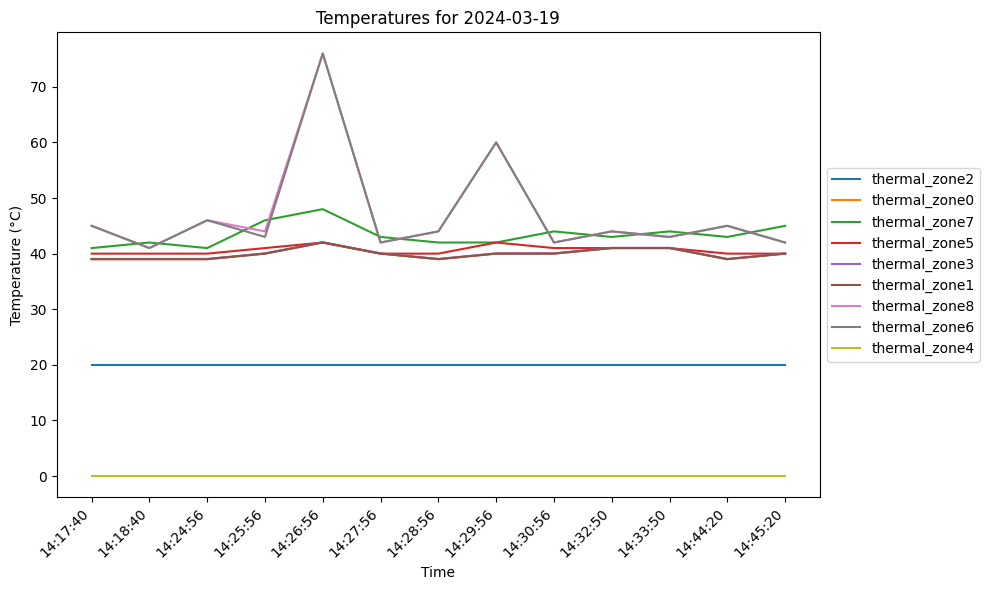

In [29]:

thermal = '/sys/class/thermal/'

def main():    
    output_file_unico = "temp_database.csv"
    output_file_varios = "temp_database_all.csv" 
    output_file_varios_teste = "temp_database_all.csv" 
    output_processor_info = "processor_info.csv"
    #Especifica a zona termal que se quer medir
   
  
''' 
    # Salvar as informacoes do processador
    thread1 = threading.Thread(target=save_processor_info, args=())
    thread1.start()
    
    # Salva as temperaturas de cada zona (1 registro por intervalo=segundo)
   # thread2 = threading.Thread(target=save_thermal_temperature_por_segundo, args=(zona, output_file_varios_teste, 10))
   # thread2.start()
    
    
    
    print("master doing thing 1")
    print("master doing thing 2")
    print("master doing thing 3")
'''   
  
    
    
if __name__ == "__main__":
    main()
    
    df = load_temperature_data()
    day_to_plot = input("Digite o dia que deseja plotar (YYYY-MM-DD): ")

    plot_temperature_graph(df, day_to_plot)